## Supervised Learning Series

# Part 2: Logistic regression

In the previous post we discussed the fitting of a linear model to a set of input/output points - otherwise known as *linear regression*.  In general all sorts of nonlinear phenomenon present themselves and the data they generate - whose input and output share a nonlinear relationship - are poorly modeled using a linear model, thus causing linear regression to perform rather poorly.  This naturally leads to the exploration of fitting *nonlinear* functions to data, referred to in general as *nonlinear regression*.

In this post we describe a very particular form of nonlinear regression called *logistic regression* that is designed to deal with a very particular kind of dataset that is commonly dealt with in machine learning / deep learning: *two-class classification data*.  This sort of data is distinguished by the fact that its output values are constrained to be either one of two fixed values.  As we will see, such a constraint naturally leads to the choice of a *logistic sigmoid function* as the ideal nonnlinear function to fit to such data, hence the name *logistic regression*.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import math
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  Setting the scene

in this Section we set the scene for logistic regression by describing the problem setup and how linear regression - as well as reasonable extensions of it - naturally fail with such data.

## 1.1 The data

Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes (i.e., it is easier to determine a proper nonlinear function to regress on the data for particular output value pairs).  We will typically use $y_{p}\in\left\{ -1,\,+1\right\}$ - that is every output takes on either the value $+1$ or $-1$.  Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  Hence a dataset containing points with label values $y_{p}\in\left\{ -1,\,+1\right\}$ is said to be a dataset consisting of two classes.

The simplest shape such a dataset can take is that of a set of linearly separated adjacent 'steps', as illustrated in the Figure below.  Here the 'bottomm' step is the region of the space containing most of the points that have label value $y_p = -1$.  The 'top step' likewise contains most of the points having label value $y_p = +1$.  These steps are largely separated by a point when $N = 2$, a line when $N = 3$, and a hyperplane when $N$ is larger (the term 'hyperplane' is also used more generally to refer to a point or line as well).  

As shown in the figure, because its output takes on a discrete set of values one can view a classification dataset 'from above'.  In this 'separator' perspective we remove the vertical $y$ dimension of the data and visually represent the dataset using its input only, displaying the output values of each point by coloring its input one of two unique colors (we choose blue for points with label $y_p = -1$, and red for those having label $y_p = +1$).  This separator view allows us to more easily identify the linear boundary that (mostly) separates the two classes.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_10.png' width="60%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> RELABEL AXES WITH X / Y  NOTATION IN ALL PANELS, ANNOTATE BOUNDARY IN EACH CASE'S LOWER PANEL Classification
from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the 'separator' perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  In the separator view the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $+1$ while those in red have label $-1$. </em>  </figcaption> 
</figure>

This is the simplest sort of dataset with binary output we could aim to perform regression on, as in general the boundary between the two classes of data could certainly be nonlinear.  We will deal with this more general potentiality later on - when discussing nerual networks, trees, and kernel-based methods - but first let us deal with the current scenario.  How can we perform regression on a dataset like the ones described in the Figure above?

## 1.2  Trying to fit a discontinuous step function

How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane?  Lets look at a simple instance of such a dataset when $N = 2$ to build our intuition abuot what must be done in general.

Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results - the line by iteslf simply too unflexible to account for the nonlinearity present in the data.  A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape.  In other words such data needs to be fit with a *step function*.

Since the boundary between the two classes is (assumed to be) linear and the labels take on values either $\pm 1$ ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  What does such a function look like?  When $N = 2$ it is simply a line $y = w_0 + w_1x_{\,}$ and compose it with the $\text{sign}(\cdot)$ function

\begin{equation}
\text{sign}\left(w_0 + w_1x_{\,} \right)
\end{equation}

Remember that the $\text{sign}(\cdot)$ function is defined as $\text{sign}(\alpha) = 
\begin{cases}
+1 \,\,\,\,\,\text{if} \,\, \alpha > 0 \\
-1 \,\,\,\,\,\text{if} \,\, \alpha < 0 \\
\end{cases}$.  Note here that what happens with $\text{sign}(0)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).

How do we tune the parameters of the line?  We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the sign function to get a step function fit.  However this does not work well in general - as we will see even in the simple instance below.  Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the line with the sign function, or in other words we need to tune the parameters of $\text{sign}\left(w_0 + w_1x_{\,} \right)$.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line and taking the sign fails to represent a two-class dataset well

In the Python cell below we load in a simple two-class dataset (top panel), fit a line to this dataset via linear regression, and then compose the fitted line with the sign function to produce a step function fit.  Both the linear fit (in green) as well as its composition with the sign function (in dashed red) are shown along with the data in the bottom panel.  Of course the line itself provides a terrible representation of the nonlinear dataset.  But its evaluation through sign is also quite poor for such a simple dataset, failing to properly identify two points on the top step.  In the parlance of classification these types of points are referred to as *misclassified points*.

<IPython.core.display.Javascript object>


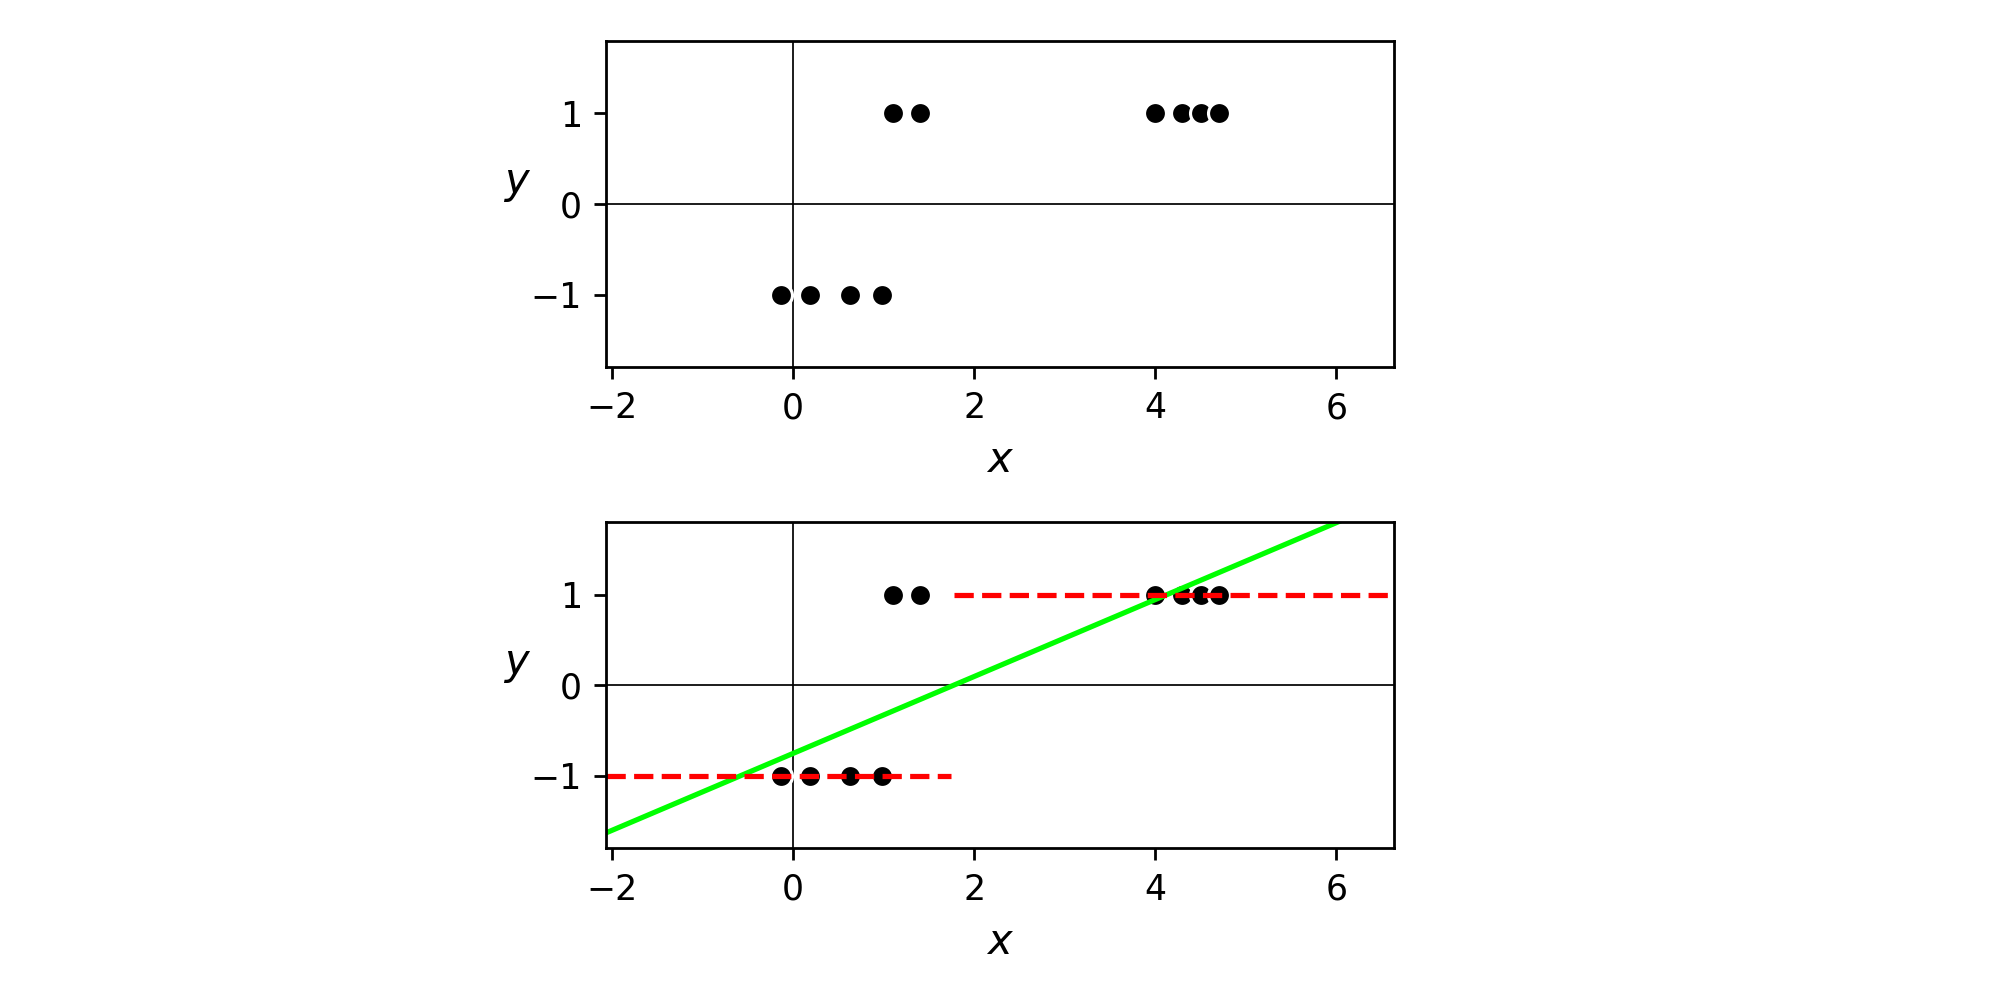

In [2]:
# load in dataset
# datapath = '../../mlrefined_datasets/superlearn_datasets/2d_logistic_data_v1.csv'
# data = np.asarray(pd.read_csv(datapath,header = None))

# load in dataset
data = np.loadtxt('2d_classification_data_v1.csv')

# create instance of linear regression demo, used below and in the next examples
demo1 = superlearn.logistic_regression_simple_demos.visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

----

How do we tune these parameters properly?  As with linear regression, here we can try to setup a proper Least Squares function that - when minimized - recovers our ideal weights. We can do this by simply reflecting on the sort of ideal relationship we want to find between the input and output of our dataset. 

Take a single point $\left(x_p,\,y_p \right)$.  Notice in the example above - and this is true more generally speaking - that ideally for a good fit we would like our weights to be such if this point has a label $+1$ it lies positive region of the space where $w_0 + w_1x > 0$ so that $\text{sign}\left(w_0 + w_1x_p\right) = +1$ matches its label value.  Likewise if this point has label $-1$ we woould like it to in the negative region where $w_0 + w_1x < 0$ so that $\text{sign}\left(w_0 + w_1x_p\right) = -1$ matches its label value.  So in short what we would ideally like for this point is that its evaluation matches its labell value, i.e., that

\begin{equation}
\text{sign}\left(w_0 + w_1x_p \right) = y_p 
\end{equation}

And of course we would like this to hold for every point.  To find weights that satisfy this set of $P$ equalities as best as possible we could - as we did previously with linear regression - square the difference between both sides of each and sum them up, giving the Least Squares function

\begin{equation}
g(\mathbf{w}) = \sum_{p=1}^P \left(\text{sign}\left(w_0 + w_1x_p \right) - y_p \right)^2
\end{equation}

and we can try to minimize this in order to recover weights that satisfy our desired equalities.  If we can find a set of weights such that $g(\mathbf{w}) = 0$ then all $P$ equalities above hold true, otherwise some of them do not.  Notice: the 'error' this Least Squares cost counts is the number of *misclassified points* for a particular choice of weights,  it is always integer valued.  Because it counts the number of misclassifications this cost function is often referred to as the *counting cost* for two-class classification.

Unfortunately because the counting cost takes on only integer values it is impossible to minimize, as at almost every point in the domain of the function it has exactly zero gradient (hence neither gradient descent or Newton's method can take a single step 'downhill' regardless of where they are initialized).

<IPython.core.display.Javascript object>


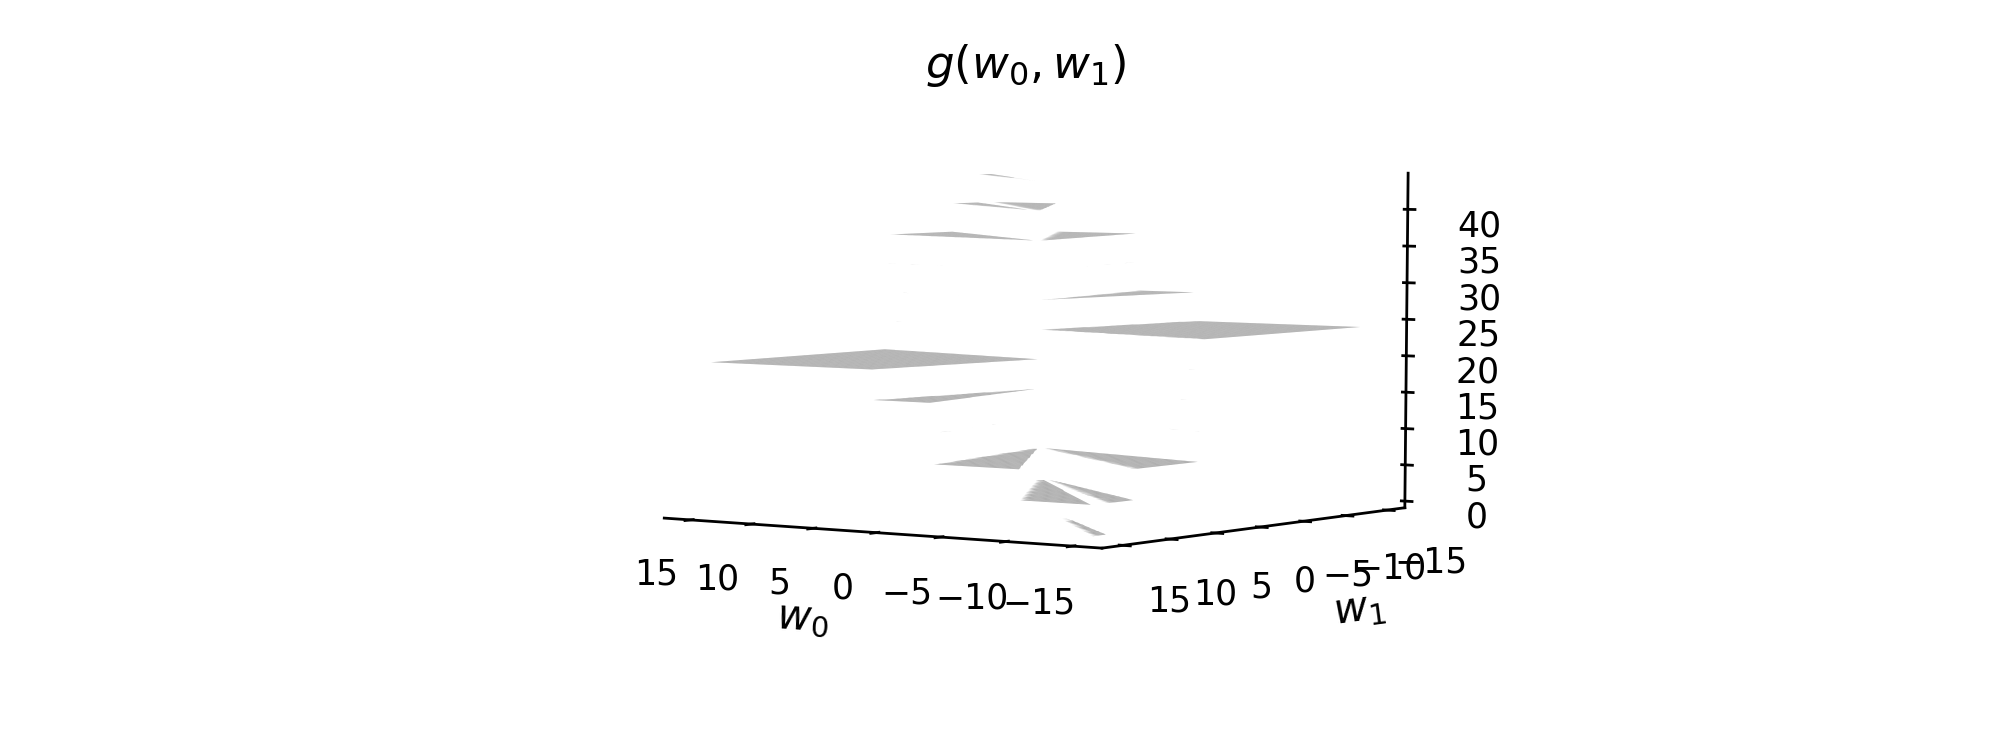

In [6]:
demo1.plot_counting_cost(viewmax = 15)

## 1.2  Relaxing the sign